In [2]:
import numpy as np
import tensorflow as tf

from mrtoct import data, ioutil

from scipy import ndimage
from skimage import filters

from matplotlib import pyplot as plt

transform = data.transform.DecodeExample()

def read_volume(path):
    return (tf.data.TFRecordDataset(path, 'GZIP')
            .map(transform)
            .make_one_shot_iterator()
            .get_next())

def remove_background(x):
    s = ndimage.binary_fill_holes(x > filters.threshold_otsu(x))
    
    x[s == 0] = 0

session = tf.Session()

/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
mr_tensor = read_volume('../data/tfrecord/training/mr.tfrecord')
ct_tensor = read_volume('../data/tfrecord/training/ct.tfrecord')

In [4]:
start = [11, 1, 0, 6, 1, 0, 1, 0, 28, 14, 0, 1, 0]
stop = [148, 131, 111, 149, 142, 148, 199, 208, 190, 199, 180, 185, 93]

In [5]:
encoder = ioutil.TFRecordEncoder()
options = ioutil.TFRecordOptions

In [6]:
mr_writer = tf.python_io.TFRecordWriter('../data/tfrecord/cleaned/mr.tfrecord', options)
ct_writer = tf.python_io.TFRecordWriter('../data/tfrecord/cleaned/ct.tfrecord', options)

In [7]:
for i in range(13):
    mr, ct = session.run([mr_tensor, ct_tensor])
    
    # remove misaligned slices
    mr = mr[start[i]:stop[i], :, :, 0]
    ct = ct[start[i]:stop[i], :, :, 0]
    
    # remove background noise
    for i in range(mr.shape[0]):
        remove_background(mr[i])
        remove_background(ct[i])
    
    # add additional axis for encoder
    mr = np.expand_dims(mr, -1)
    ct = np.expand_dims(ct, -1)
    
    mr_writer.write(encoder.encode(mr))
    ct_writer.write(encoder.encode(ct))

In [8]:
mr_writer.close()
ct_writer.close()

In [301]:
mr_tensor = read_volume('../data/tfrecord/training/mr.tfrecord')
ct_tensor = read_volume('../data/tfrecord/training/ct.tfrecord')

mr, ct = session.run([mr_tensor, ct_tensor])

mr = mr[start[0]:stop[0], :, :, 0]
ct = ct[start[0]:stop[0], :, :, 0]

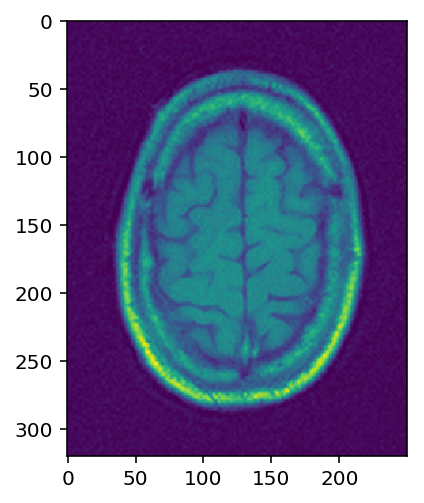

In [302]:
plt.imshow(mr[0])

In [13]:
mr_clean_tensor = read_volume('../data/tfrecord/cleaned/ct.tfrecord')

In [14]:
mr_clean = session.run(mr_clean_tensor)


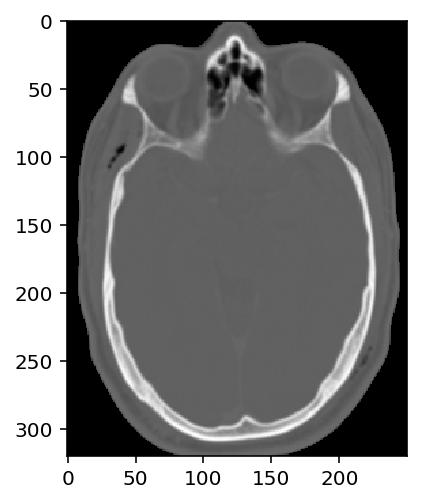

In [64]:
image = mr_clean[100,:,:,0]

plt.imshow(image, cmap='gray')

In [194]:
def extract_brain(x):
    m1 = np.where(x > 1300, np.ones_like(x), np.zeros_like(x))
    m2 = np.copy(m1)
    
    for i in range(m1.shape[0]):
        start, stop = 0, 0
        
        grad = np.gradient(m1[i].astype(np.float32))
        
        start = (grad == -0.5).argmax()
        stop = (grad[start:] == +0.5).argmax() + start

        if stop > start and start < 100:
            m2[i, start:stop] = 1
    
    return np.where(m2-m1 == 1, x, np.zeros_like(x))

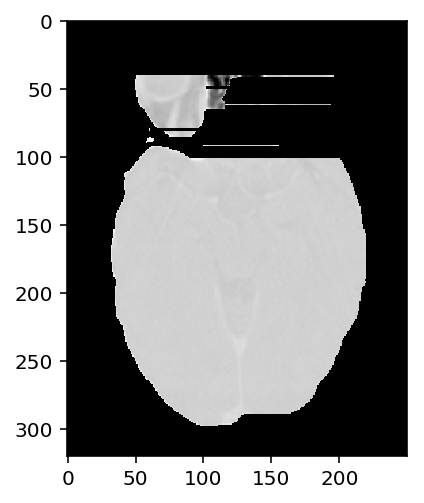

In [195]:
plt.imshow(extract_brain(mr_clean[100,:,:,0]), cmap='gray')

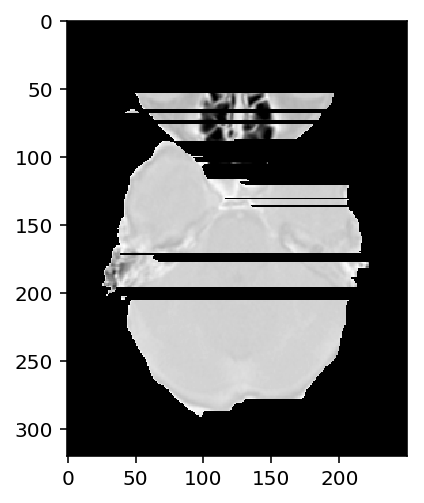

In [198]:
plt.imshow(extract_brain(mr_clean[120,:,:,0]), cmap='gray')

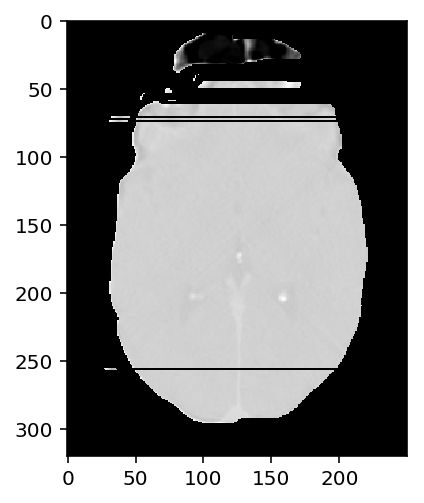

In [199]:
plt.imshow(extract_brain(mr_clean[80,:,:,0]), cmap='gray')

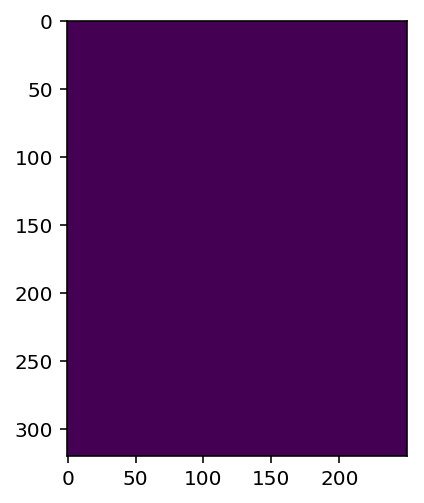

In [191]:
plt.imshow(segmentation)